In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('data/tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## Data Preprocessing

In [3]:
# drop unwanted columns
df.drop(['textID', 'selected_text'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [5]:
# drop nan value from dataframe
df.dropna(inplace=True)

In [6]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

In [7]:
# convert the text into string and lower case
df['text'] = df['text'].astype(str).str.lower()

In [8]:
#remove urls, user mentions, hashtags, numbers and special character
df['text'] = df['text'].str.replace(r'https?://\S+|@\w+|#|\d|[^\w\s]', '', regex=True) 

In [9]:
# tokenization
df['token'] = df['text'].apply(word_tokenize)

In [10]:
# lemmitization
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text) 
    return [token.lemma_ for token in doc]

df['token'] = df['text'].apply(lemmatize_text)

In [11]:
# remove stopwords
stop_words = set(stopwords.words('english'))
df['token'] = df['token'].apply(lambda x: [value for value in x if value not in stop_words])

In [12]:
# Remove empty strings and underscores from tokens
df['token'] = df['token'].apply(lambda x: [word for word in x if word not in ['', 'I', '_'] and not word.isspace()])

In [13]:
df.head()

,text,sentiment,token
0,id have responded if i were going,neutral,"[respond, go]"
1,sooo sad i will miss you here in san diego,negative,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me,negative,"[boss, bully]"
3,what interview leave me alone,negative,"[interview, leave, alone]"
4,sons of why couldnt they put them on the rel...,negative,"[son, could, put, release, already, buy]"


## EDA

In [14]:
# combine all tokens to a list
combine_tokens = sum(df['token'].tolist(), [])

In [15]:
# calculate frequency distribution
frequency = FreqDist(combine_tokens)

In [16]:
# top 20 most common words
print(frequency.most_common(20))

[('go', 3243), ('get', 3116), ('day', 2414), ('good', 1841), ('work', 1470), ('like', 1439), ('love', 1333), ('see', 1186), ('well', 1177), ('today', 1105), ('time', 1071), ('one', 1052), ('know', 1036), ('think', 1035), ('happy', 990), ('want', 979), ('make', 970), ('miss', 960), ('lol', 953), ('thank', 941)]


In [17]:
# words and frequencies
words, freq = zip(*frequency.most_common(10))

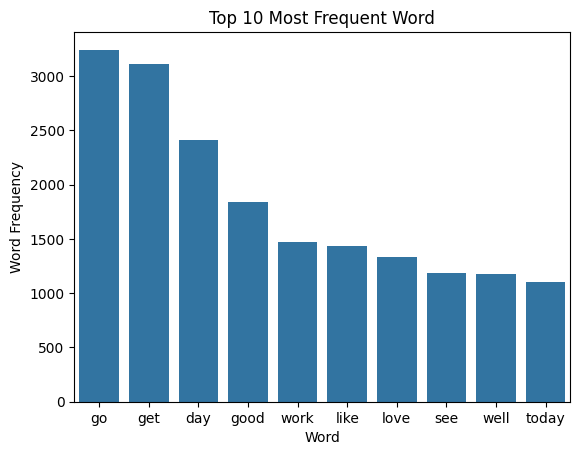

In [18]:
sns.barplot(x=words, y=freq)
plt.title('Top 10 Most Frequent Word')
plt.xlabel('Word')
plt.ylabel('Word Frequency')
plt.show()

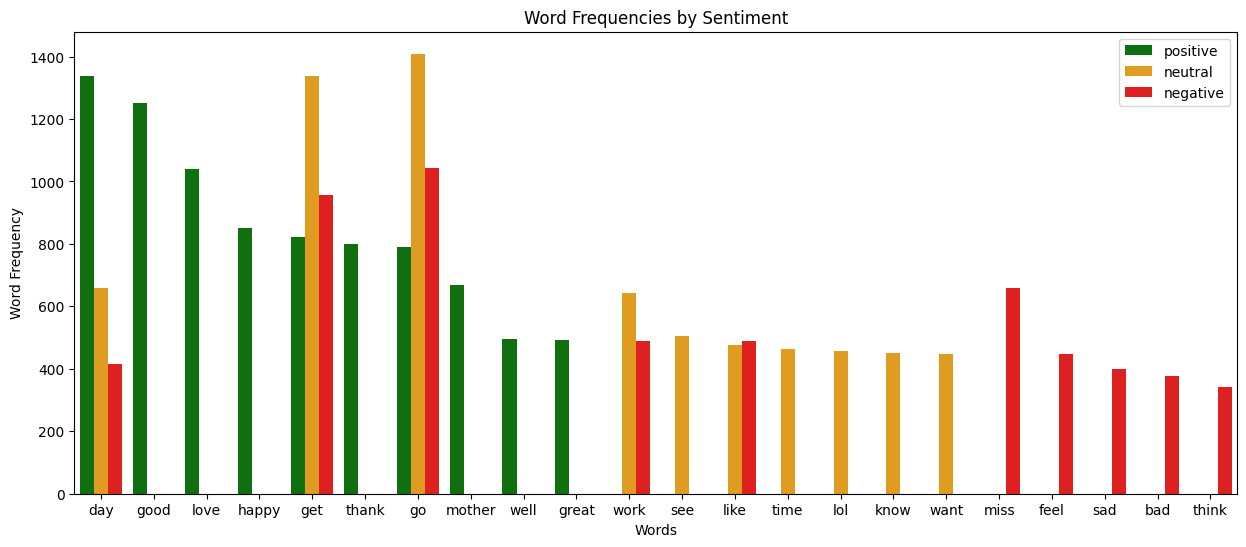

In [19]:
# all the sentiment token
positive_token = sum(df[df['sentiment'] == 'positive']['token'].tolist(), [])
neutral_token = sum(df[df['sentiment'] == 'neutral']['token'].tolist(), [])
negative_token = sum(df[df['sentiment'] == 'negative']['token'].tolist(), [])

# frequencies for each sentiment and top 10 values
positive_frequency = FreqDist(positive_token).most_common(10)
neutral_frequency = FreqDist(neutral_token).most_common(10)
negative_frequency = FreqDist(negative_token).most_common(10)

token = []
frequency = []
sentiment = []

# positive tokens to list
for word, freq in positive_frequency:
    token.append(word)
    frequency.append(freq)
    sentiment.append('positive')

# neutral tokens to list
for word, freq in neutral_frequency:
    token.append(word)
    frequency.append(freq)
    sentiment.append('neutral')

# negative tokens to list
for word, freq in negative_frequency:
    token.append(word)
    frequency.append(freq)
    sentiment.append('negative')


plt.figure(figsize=(15, 6))
sns.barplot(x=token, y=frequency, hue=sentiment, palette=['green', 'orange', 'red'])
plt.title('Word Frequencies by Sentiment')
plt.ylabel('Word Frequency')
plt.xlabel('Words')
plt.show()

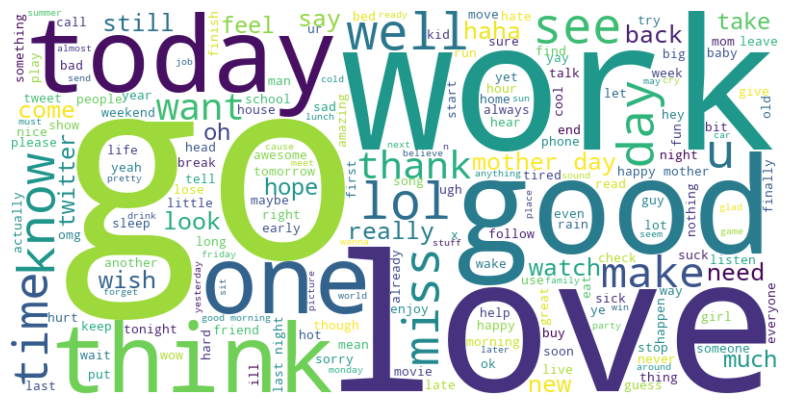

In [20]:
# token to string
text = ' '.join(sum(df['token'].tolist(), []))

# create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
# label encoder
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# mapping of the data
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}

In [23]:
X = df['text']
y = df['sentiment']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Engineering

In [25]:
import joblib

In [26]:
# vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [27]:
# model save
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## Model Trainning

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score 

In [29]:
# train logistic regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [30]:
# prediction of logistic regression model
y_pred_logistic_regression = logistic_regression.predict(X_test)

In [31]:
# train naive bayes model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [32]:
# prediction of naive bayes model
y_pred_naive_bayes = naive_bayes.predict(X_test)

In [33]:
# train svm model
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [34]:
# prediction of svm model
y_pred_svm = svm.predict(X_test)

In [ ]:
# train random forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

In [ ]:
# prediction of random forest model
y_pred_random_forest = random_forest.predict(X_test)

In [ ]:
# train xgboost model
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

In [ ]:
# prediction of xgboost model
y_pred_xgboost = xgboost.predict(X_test)

## Model Evaluation

In [ ]:
print(classification_report(y_test, y_pred_logistic_regression))

In [ ]:
# heatmap with confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_logistic_regression), annot=True, fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Value Label')
plt.ylabel('Actual Value Label')
plt.title('Confusion Matrix Heatmap - Logistic Regression')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_naive_bayes))

In [ ]:
# heatmap with confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_naive_bayes), annot=True, fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Value Label')
plt.ylabel('Actual Value Label')
plt.title('Confusion Matrix Heatmap - Naive Bayes')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
# heatmap with confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Value Label')
plt.ylabel('Actual Value Label')
plt.title('Confusion Matrix Heatmap - SVM')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_random_forest))

In [ ]:
# heatmap with confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_random_forest), annot=True, fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Value Label')
plt.ylabel('Actual Value Label')
plt.title('Confusion Matrix Heatmap - Random Forest')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_xgboost))

In [ ]:
# heatmap with confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgboost), annot=True, fmt='d', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Value Label')
plt.ylabel('Actual Value Label')
plt.title('Confusion Matrix Heatmap - XGBoost')
plt.show()

In [ ]:
# model save
joblib.dump(svm, 'svm_model.pkl')

In [ ]:
# model save
joblib.dump(random_forest, 'random_forest.pkl')